In [22]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-01-24 18:57:30.164668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30519 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6135845116517482139,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 32002277376
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12752560875659856906
 physical_device_desc: "device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0"]

In [23]:
import os
print(os.listdir('./data/flowers'))

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [24]:
# GPU 관련
import os
import tensorflow as tf

In [25]:
# warnings 처리를 위함
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [26]:
# 데이터 시각화를 위함
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [27]:
# model selection
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_recall_curve, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [28]:
# preprocess
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [29]:
# keras 관련 라이브러리
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random, PIL

In [30]:
# CNN 관련 모듈
from tensorflow.keras.layers import Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [31]:
batch_size = 32
img_height = 150
img_width = 150

In [32]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  './data/flowers',
  validation_split = 0.2,
  subset = "training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [33]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  './data/flowers',
  validation_split = 0.2,
  subset = "validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [34]:
class_names = train_ds.class_names

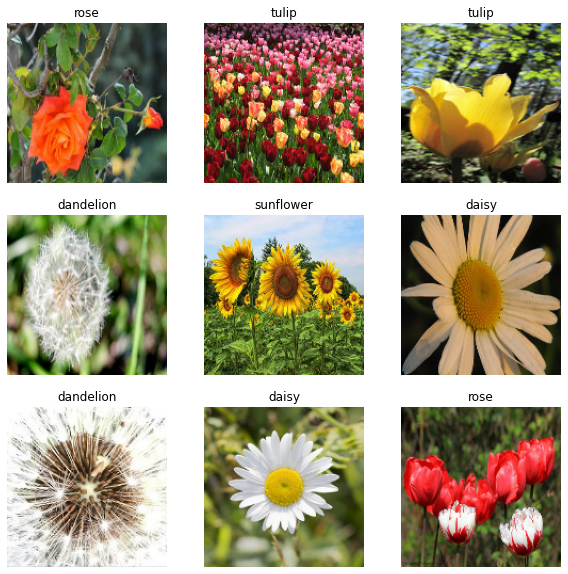

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [37]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = val_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [39]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

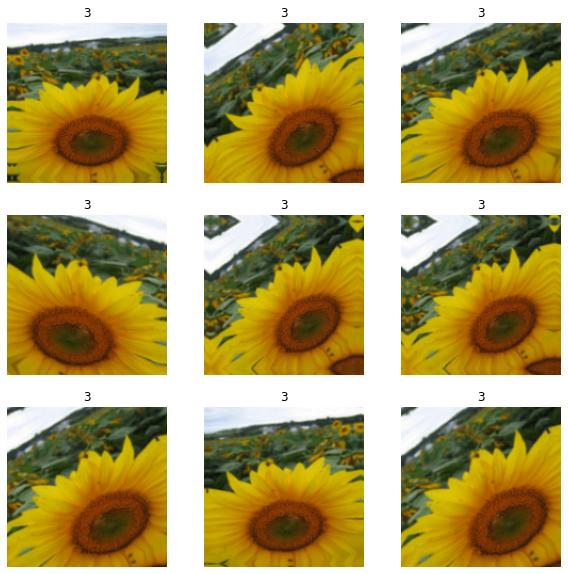

In [40]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [41]:
from keras.applications.vgg19 import VGG19
from keras.layers import GlobalAveragePooling2D

base_model = VGG19(input_shape=(img_width, img_height, 3), 
                   include_top=False, 
                   weights='imagenet')
base_model.trainable=False

global_average_layer = GlobalAveragePooling2D()

In [42]:
VGGmodel = tf.keras.Sequential([
  base_model,
  global_average_layer,
  Flatten(),
  Dense(4096, activation="relu"),
  Dense(4096, activation="relu"),
  Dense(5, activation="softmax")
])

In [43]:
opt = Adam(lr=0.001)
VGGmodel.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy'])

In [44]:
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

learning_rate_reduction=ReduceLROnPlateau(monitor="val_loss",
                                          patience=3,
                                          factor = 0.5,
                                          min_lr=0.0001,
                                          verbose=1)

earlystop = EarlyStopping(patience=10)

checkpoint_path = "training/cpFalse.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [earlystop, learning_rate_reduction, cp_callback]

In [45]:
history = VGGmodel.fit(
                        train_ds,
                        validation_data=val_ds,
                        epochs=50,
                        callbacks=[callbacks]
                                              )

Epoch 1/50


2022-01-24 19:01:30.768805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


108/108 [==============================] - 9s 51ms/step - loss: 2.6575 - sparse_categorical_accuracy: 0.7108 - val_loss: 0.6464 - val_sparse_categorical_accuracy: 0.7914

Epoch 00001: saving model to training/cpFalse.ckpt
Epoch 2/50
108/108 [==============================] - 4s 36ms/step - loss: 0.3990 - sparse_categorical_accuracy: 0.8573 - val_loss: 0.6552 - val_sparse_categorical_accuracy: 0.8030

Epoch 00002: saving model to training/cpFalse.ckpt
Epoch 3/50
108/108 [==============================] - 4s 38ms/step - loss: 0.2257 - sparse_categorical_accuracy: 0.9207 - val_loss: 0.8440 - val_sparse_categorical_accuracy: 0.7937

Epoch 00003: saving model to training/cpFalse.ckpt
Epoch 4/50
108/108 [==============================] - 4s 35ms/step - loss: 0.1737 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.7879

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: saving model to training/cpFalse.ckp

In [46]:
VGGmodel.save('using_VGG19_whole2.h5')
VGGmodel.save_weights('using_VGG19_weights2.h5')

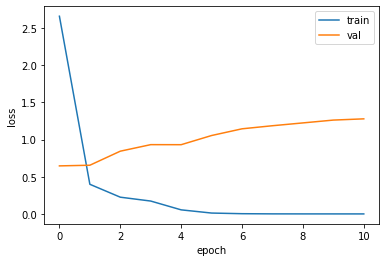

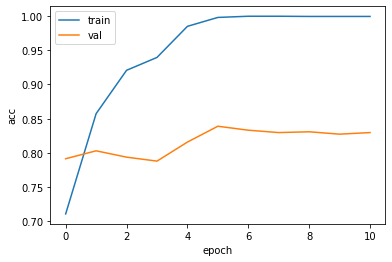

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'])
plt.show()

In [48]:
test_image_path = './data/test/rose_test.png'
img = tf.keras.utils.load_img(
    test_image_path, grayscale=False, color_mode='rgb', target_size=(img_height, img_width),
    interpolation='nearest'
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = VGGmodel.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진속 꽃은 {} 와 {:.2f} 퍼센트 일치합니다"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

이 사진속 꽃은 rose 와 40.45 퍼센트 일치합니다
